## Use neural net to predict reward from observation and action to speed up the learning

In [1]:
!pip install pybullet==2.5.5

%cd /usr/local/lib/python3.6/dist-packages
!git clone https://github.com/benelot/pybullet-gym.git
%cd pybullet-gym
!pip install -e .
%cd /content

/usr/local/lib/python3.6/dist-packages
fatal: destination path 'pybullet-gym' already exists and is not an empty directory.
/usr/local/lib/python3.6/dist-packages/pybullet-gym
Obtaining file:///usr/local/lib/python3.6/dist-packages/pybullet-gym
  Found existing installation: pybulletgym 0.1
    Can't uninstall 'pybulletgym'. No files were found to uninstall.
  Running setup.py develop for pybulletgym
/content


In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from copy import deepcopy

import gym
import pybulletgym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
from tqdm import trange
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
import pickle
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, requires_grad=False):
    x = torch.from_numpy(x)
    
    if requires_grad:
        return x.clone().contiguous().detach().requires_grad_(True).to(device)
    else:
        return x.clone().contiguous().detach().to(device)

device

'cuda'

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(119, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 1))
        self.loss = nn.MSELoss()
        
        
    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
        

class AgentNetwork(nn.Module):
    
    def __init__(self):
        super(AgentNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(111, 100),
            nn.Tanh(),
            nn.Linear(100, 8),
            nn.Tanh()
        )

        
    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
    
    
    def set_params(self, params):
        cpt = 0
        for param in self.parameters():
            tmp = np.product(param.size())

            if torch.cuda.is_available():
                param.data.copy_(to_tensor(
                    params[cpt:cpt + tmp]).view(param.size()).cuda())
            else:
                param.data.copy_(to_tensor(
                    params[cpt:cpt + tmp]).view(param.size()))
            cpt += tmp

            
    def get_params(self):
        return deepcopy(np.hstack([to_np(v).flatten() for v in
                                   self.parameters()]))

In [4]:
class CEM:
    
    def __init__(self, net, no_params, max_steps, max_eval_steps, sigma_st, sigma_end, tau, pop_size, elitist=None):
        self.net = net
        self.max_steps = max_steps
        self.max_eval_steps = max_eval_steps
        self.sigma_st = sigma_st
        self.sigma_end = sigma_end
        self.tau = tau
        self.pop_size = pop_size
        self.elitist = elitist
        
        if self.elitist is None:
            self.elitist = int(self.pop_size//2)
        
        self.no_params = no_params
        
        self.df = pd.DataFrame({'total_steps':[], 'min_eval': [], 'mean_eval': [], 'max_eval': [], 'mean_sigma': [], 'max_sigma': []})
        
    
    def run(self):
        raise NotImplementedError
                
    
    def _draw_population(self, mu, sigma):
        pop = np.zeros((self.pop_size, self.no_params))
        for i in range(self.pop_size):
            pop[i] = np.random.normal(mu, np.sqrt(sigma))
        return pop

    
    def _eval(self, actor, obs):
        '''
        evals actor by generating sample from given observation distribution and use nn to predict reward based on action
        
        returns mean reward gained during eval
        '''
        with torch.no_grad():
            actions = actor(obs)
            obs_actions = torch.cat((obs, actions), 1)
            reward = self.net(obs_actions)
        return to_np(reward).mean()
        
    
    
    def _update_params(self, pop, evals, old_mu, old_sigma, epsilon):
        lambdas = np.array([np.log(1+self.elitist)/(1+i) for i in range(self.elitist)]).reshape(-1, 1)
        lambdas /= (lambdas.sum()+1e-10)
#         lambdas = np.full(self.elitist, 1/self.elitist)
        idxs = np.argsort(evals)[::-1][:self.elitist]
        z = pop[idxs]
        
        mu = np.sum([lambdas[i]*z[i] for i in range(self.elitist)], axis=0)

        sigma = np.sum([lambdas[i]*(z[i] - old_mu)**2 for i in range(self.elitist)], axis=0)
        sigma += epsilon
        
        sigma = np.clip(sigma, 0.4, 20)
        
        return mu, sigma

In [5]:
class CEM_data(CEM):
    def __init__(self, net, no_params, max_steps, max_eval_steps, sigma_st, 
                 sigma_end, tau, pop_size):
        super(CEM_data, self).__init__(net, no_params, max_steps, max_eval_steps, sigma_st, sigma_end, tau, pop_size)

    def run(self):
        actor = AgentNetwork().to(device)
        
        mu = np.ones(self.no_params)
        sigma = self.sigma_st
        epsilon = 4
        
        total_steps = actor_steps = 0
        
        best, best_eval = None, -np.inf
        
        for total_steps in trange(self.max_steps, position=0, leave=True):
            if total_steps % 10 == 0:
                idx = (total_steps//10) % 10
                data = pickle.load(open(f'drive/My Drive/project_evo/data/b{idx}.pkl', 'rb'))['X'][:, :111].to(device)
            pop = self._draw_population(mu, sigma)

            evals = np.zeros(self.pop_size)
            for i in range(self.pop_size):
                actor.set_params(pop[i])
                idxs = np.random.choice(len(data), self.max_eval_steps, replace=False)
                evals[i] = self._eval(actor, data[idxs])
            
            evals = np.maximum(0, evals)

            
            mu, sigma = self._update_params(pop, evals, mu, sigma, epsilon)
            epsilon = self.tau*epsilon + (1-self.tau)*(np.mean(self.sigma_end))
            

            if evals.max() > best_eval:
                best, best_eval = pop[np.argmax(evals)], evals.max()
                
            if total_steps % 5 == 0:
                self.df = self.df.append({'total_steps': total_steps, 'min_eval': evals.min(), 'mean_eval': evals.mean(), 'max_eval': evals.max(), 'mean_sigma': sigma.mean(), 'max_sigma': sigma.max()}, ignore_index=True)
            
            if total_steps % 200 == 0:
                to_write = {'params': {'mu': mu, 'sigma': sigma, 'epsilon': epsilon},
                           'pop': pop,
                           'best': best}
                pickle.dump(to_write, open(f'drive/My Drive/project_evo/history/from_data/{total_steps}.pkl', 'w+b'), 
                            pickle.HIGHEST_PROTOCOL)
                best, best_eval = None, -np.inf
            
        return best


class CEM_gen(CEM):
    
    def __init__(self, net, obs_mean, obs_std, no_params, max_steps, max_eval_steps, sigma_st, 
                 sigma_end, tau, pop_size):
        super(CEM_gen, self).__init__(net, no_params, max_steps, max_eval_steps, sigma_st, sigma_end, tau, pop_size)
        self.obs_mean = obs_mean
        self.obs_std = obs_std

    def run(self):
        actor = AgentNetwork().to(device)
        
        mu = np.ones(self.no_params)
        sigma = self.sigma_st
        epsilon = 4
        
        total_steps = actor_steps = 0
        
        best, best_eval = None, -np.inf
        
        for total_steps in trange(self.max_steps, position=0, leave=True):
            pop = self._draw_population(mu, sigma)

            evals = np.zeros(self.pop_size)
            obs = torch.Tensor([np.random.normal(self.obs_mean, self.obs_std) for _ in range(self.max_eval_steps)]).to(device)
            for i in range(self.pop_size):
                actor.set_params(pop[i])
                evals[i] = self._eval(actor, obs)
            
            evals = np.maximum(0, evals)


            mu, sigma = self._update_params(pop, evals, mu, sigma, epsilon)
            epsilon = self.tau*epsilon + (1-self.tau)*(np.mean(self.sigma_end))
            

            if evals.max() > best_eval:
                best, best_eval = pop[np.argmax(evals)], evals.max()
                
            if total_steps % 5 == 0:
                self.df = self.df.append({'total_steps': total_steps, 'min_eval': evals.min(), 'mean_eval': evals.mean(), 'max_eval': evals.max(), 'mean_sigma': sigma.mean(), 'max_sigma': sigma.max()}, ignore_index=True)
            
            if total_steps % 200 == 0:
                to_write = {'params': {'mu': mu, 'sigma': sigma, 'epsilon': epsilon},
                           'pop': pop,
                           'best': best}
                pickle.dump(to_write, open(f'drive/My Drive/project_evo/history/from_gen/{total_steps}.pkl', 'w+b'), 
                            pickle.HIGHEST_PROTOCOL)
                # best, best_eval = None, -np.inf
            
        return best

### Find distribution of observations to generate new similar to them

In [7]:
means, stds = [], []
for b in trange(10, position=0, leave=True):
    d = pickle.load(open(f'drive/My Drive/project_evo/data/b{b}.pkl', 'rb'))
    X = to_np(d['X'])[:, :111]
    means.append(X.mean(axis=0))
    stds.append(X.std(axis=0))

100%|██████████| 10/10 [01:15<00:00,  7.59s/it]


In [8]:
obs_mean = np.mean(means, axis=0)
obs_std = np.mean(stds, axis=0)

In [9]:
obs = torch.Tensor([np.random.normal(obs_mean, obs_std).astype(np.float32) for _ in range(50)])
actor = AgentNetwork()
actions = actor(obs)
torch.cat((obs, actions), 1).size()

torch.Size([50, 119])

In [7]:
net = pickle.load(open('drive/My Drive/project_evo/reward_pred/net.pkl', 'rb')).to(device)

In [14]:
cem_gen = CEM_gen(net, obs_mean, obs_std, no_params=12008, max_steps=10000, max_eval_steps=1000, 
          sigma_st=np.full(12008, 2), sigma_end=np.full(12008, 1e-5), tau=0.99, pop_size=250)

In [15]:
best = cem_gen.run()

100%|██████████| 10000/10000 [1:26:41<00:00,  1.92it/s]


In [16]:
pickle.dump(best, open('drive/My Drive/project_evo/history/from_gen/best.pkl', 'w+b'), pickle.HIGHEST_PROTOCOL)

In [17]:
pickle.dump(cem_gen, open('drive/My Drive/project_evo/history/from_gen/cem.pkl', 'w+b'), pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [6]:
cem_gen = pickle.load(open('drive/My Drive/project_evo/history/from_gen/cem.pkl', 'rb'))

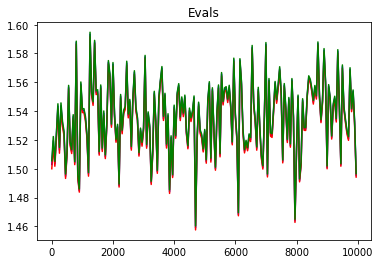

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(cem_gen.df))[::10]*5, cem_gen.df['mean_eval'][::10], c='b')
plt.plot(np.arange(len(cem_gen.df))[::10]*5, cem_gen.df['min_eval'][::10], c='r')
plt.plot(np.arange(len(cem_gen.df))[::10]*5, cem_gen.df['max_eval'][::10], c='g')
plt.title('Evals')
plt.show()

### Use real collected data to train

In [10]:
cem_data = CEM_data(net, no_params=12008, max_steps=5000, max_eval_steps=1000, 
          sigma_st=np.full(12008, 2), sigma_end=np.full(12008, 1e-5), tau=0.99, pop_size=250)

In [11]:
best = cem_data.run()

100%|██████████| 5000/5000 [2:49:35<00:00,  2.04s/it]


In [12]:
pickle.dump(best, open('drive/My Drive/project_evo/history/from_data/best.pkl', 'w+b'), pickle.HIGHEST_PROTOCOL)
pickle.dump(cem_data, open('drive/My Drive/project_evo/history/from_data/cem.pkl', 'w+b'), pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [11]:
cem_data = pickle.load(open('drive/My Drive/project_evo/history/from_data/cem.pkl', 'rb'))

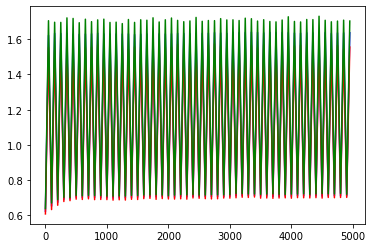

In [12]:
plt.plot(np.arange(len(cem_data.df))[::10]*5, cem_data.df['mean_eval'][::10], c='b')
plt.plot(np.arange(len(cem_data.df))[::10]*5, cem_data.df['min_eval'][::10], c='r')
plt.plot(np.arange(len(cem_data.df))[::10]*5, cem_data.df['max_eval'][::10], c='g')